# 1. 얼굴 찾기

In [40]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

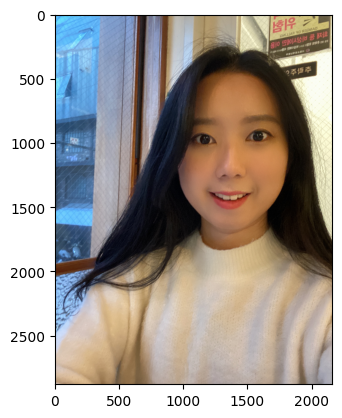

In [59]:
# 내 사진 불러오기
my_image_path = "./Images/selfie.png"
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [42]:
# 얼굴 감지기 선언하기
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

In [43]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)

rectangles[[(958, 781) (1756, 1579)]]


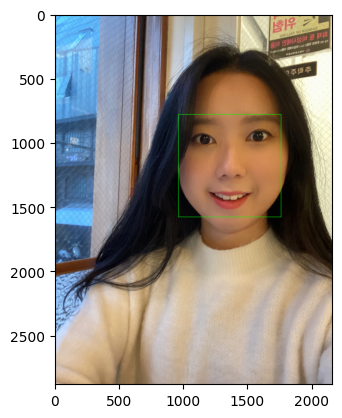

In [44]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 2. 얼굴 랜드마크

In [45]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! mv shape_predictor_68_face_landmarks.dat.bz2 ./Models/

--2024-11-24 06:17:13--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  44.5MB/s    in 1.4s    

2024-11-24 06:17:14 (44.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [46]:
! bzip2 -d ./Models/shape_predictor_68_face_landmarks.dat.bz2

bzip2: Output file ./Models/shape_predictor_68_face_landmarks.dat already exists.


In [47]:
model_path = "./Models/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

In [48]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


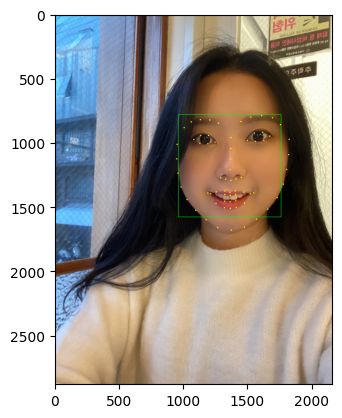

In [49]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 꽤나 랜드마크 인식을 잘한 듯 함!
- 포인트 사이즈 5 이상 넣어야 사진에서 잘 보이는 듯 함
- 고양이 수염 붙일 때 코가 31번 ~ 30번 사이에 위치하도록 붙이는게 좋을 듯 함

In [50]:
# 30번 좌표 값 출력
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print(f"(x, y): ({x}, {y})")
    print(f"(w, h): ({w}, {h})")

(1362, 1211)
(x, y): (1362, 1211)
(w, h): (799, 799)


In [51]:
!cd ./Images && ls -a

.  ..  cat-whiskers.png  selfie.png


In [52]:
sticker_path = "./Images/cat-whiskers.png"
img_sticker = cv2.imread(sticker_path)

In [53]:
img_sticker.shape

(512, 512, 3)

In [54]:
# 이미지의 사이즈가 (512, 512, 3)으로 정방형이라 동일하게 resize 해주어도 됨!
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker.shape

(799, 799, 3)

In [55]:
# 이미지의 시작점은 top-left가 되어야 하므로 x,y 좌표 조정이 필요함
# x는 이미지에서 코 부위의 x값 = 1362
# y는 이미지에서 코 부위의 y값 = 1211
# x는 코에서 이미지 width 1/2 좌측으로 이동한 값이어야 중앙에 위치함
# y도 코에서 이미지 height 1/2 위로 이동해야 함

refined_x = x - w//2
refined_y = y - h//2

print(f"(x, y) : ({refined_x}, {refined_y})")

(x, y) : (963, 812)


In [56]:
# 이미지에 스티커 적용하기
sticker_area = img_show[refined_y: refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

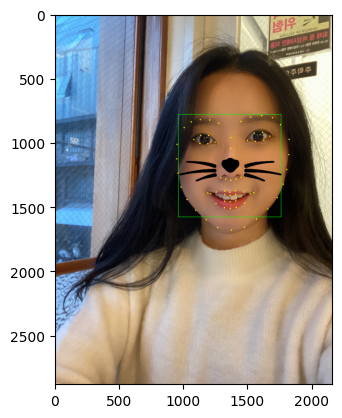

In [57]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

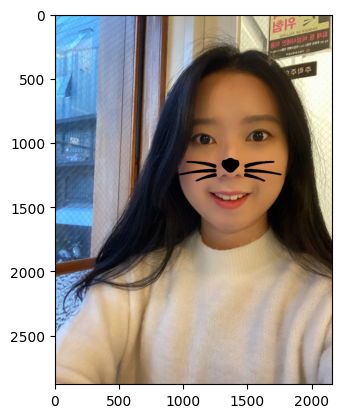

In [60]:
# bounding box, landmark 제거 후 최종 결과만 출력
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()